# CEERS NIRCam Trilogy color images

[CEERS SDR3](https://ceers.github.io/sdr3.html) Simulated Data Release 3 NIRCam images in 6 filters  
https://ceers.github.io/sdr3.html

[Trilogy](https://www.stsci.edu/~dcoe/trilogy) adapted for use in a Python 3 Jupyter notebook

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import join
from os.path import expanduser
home = expanduser("~")

import astropy
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, LinearStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from importlib import reload

from scipy.optimize import golden  # for Trilogy

In [2]:
#%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [3]:
# Trilogy color images
# https://www.stsci.edu/~dcoe/trilogy

from scipy.optimize import golden

def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1**n
    a1n = np.abs(a1n)  # Don't want the solutions where a1 & a2 are both negative!
    da1 = a1n - a2
    k = np.abs(k)
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k  # To avoid solution k = 0!
    return abs(da1)

def imscale2(data, levels, y1):
    # x0, x1, x2  YIELD  0, y1, 1,  RESPECTIVELY
    # y1 = noiselum
    global n, x0, x1, x2  # So that golden can use them
    x0, x1, x2 = levels  
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = np.abs(golden(da))
    r1 = np.log10( k * (x2 - x0) + 1)
    v = np.ravel(data)
    v = clip2(v, 0, None)
    d = k * (v - x0) + 1
    d = clip2(d, 1e-30, None)
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    z = z * 255
    z = z.astype(np.uint8)
    return z

def clip2(m, m_min=None, m_max=None):
    if m_min == None:
        m_min = np.min(m)
    if m_max == None:
        m_max = np.max(m)
    return np.clip(m, m_min, m_max)


# PREVIOUSLY in colorimage.py
def set_levels(data, pp, stripneg=False, sortedalready=False):
    if sortedalready:
        vs = data
    else:
        print('sorting...')
        vs = np.sort(data.flat)
    if stripneg:  # Get rid of negative values altogether!
        # This is the way I was doing it for a while
        # Now that I'm not, resulting images should change (get lighter)
        i = np.searchsorted(vs, 0)
        vs = vs[i+1:]
    else:  # Clip negative values to zero
        vs = clip2(vs, 0, None)
    ii = np.array(pp) * len(vs)
    ii = ii.astype(int)
    ii = np.clip(ii, 0, len(vs)-1)
    levels = vs.take(ii)
    #print ii, levels, vs, sort(vs)
    return levels


def determine_scaling(data, unsatpercent, noisesig=1, correctbias=True, noisesig0=2):
    """Determines data values (x0,x1,x2) which will be scaled to (0,noiselum,1)"""
    # Robust mean & standard deviation
    datasorted = data + 0
    datasorted[np.isnan(datasorted)]=0  # set all nan values to zero
    datasorted = np.sort(datasorted.flat)
    if datasorted[0] == datasorted[-1]:  # data is all one value
        levels = 0, 1, 100  # whatever
    else:
        data_mean, data_median, data_stddev = sigma_clipped_stats(datasorted)
        m = data_mean
        r = data_stddev
        print('%g +/- %g' % (m, r))

        if correctbias:
            x0 = m - noisesig0 * r
        else:
            x0 = 0
        x1 = m + noisesig * r
        x2 = set_levels(datasorted, np.array([unsatpercent]), sortedalready=True)[0]
        levels = x0, x1, x2
    return levels

def image_stamps(data, sample_size=1000, dx=0, dy=0):
    ny, nx, three = data.shape
    #print(data.shape)
    yc = int(ny / 2)
    xc = int(nx / 2)
    #print(xc, yc)
    #print(xc+dx, yc+dy)
    
    ylo = yc - sample_size / 2 + dy
    yhi = yc + sample_size / 2 + dy

    xlo = xc - sample_size / 2 + dx
    xhi = xc + sample_size / 2 + dx
    #print(xlo, xhi, ylo, yhi)
    
    ylo = int(np.clip(ylo, 0, ny))
    yhi = int(np.clip(yhi, 0, ny))
    xlo = int(np.clip(xlo, 0, nx))
    xhi = int(np.clip(xhi, 0, nx))
    #print(xlo, xhi, ylo, yhi)

    stamps = data[ylo:yhi,xlo:xhi]
    return stamps

# View images in each filter (optional)

<IPython.core.display.Javascript object>


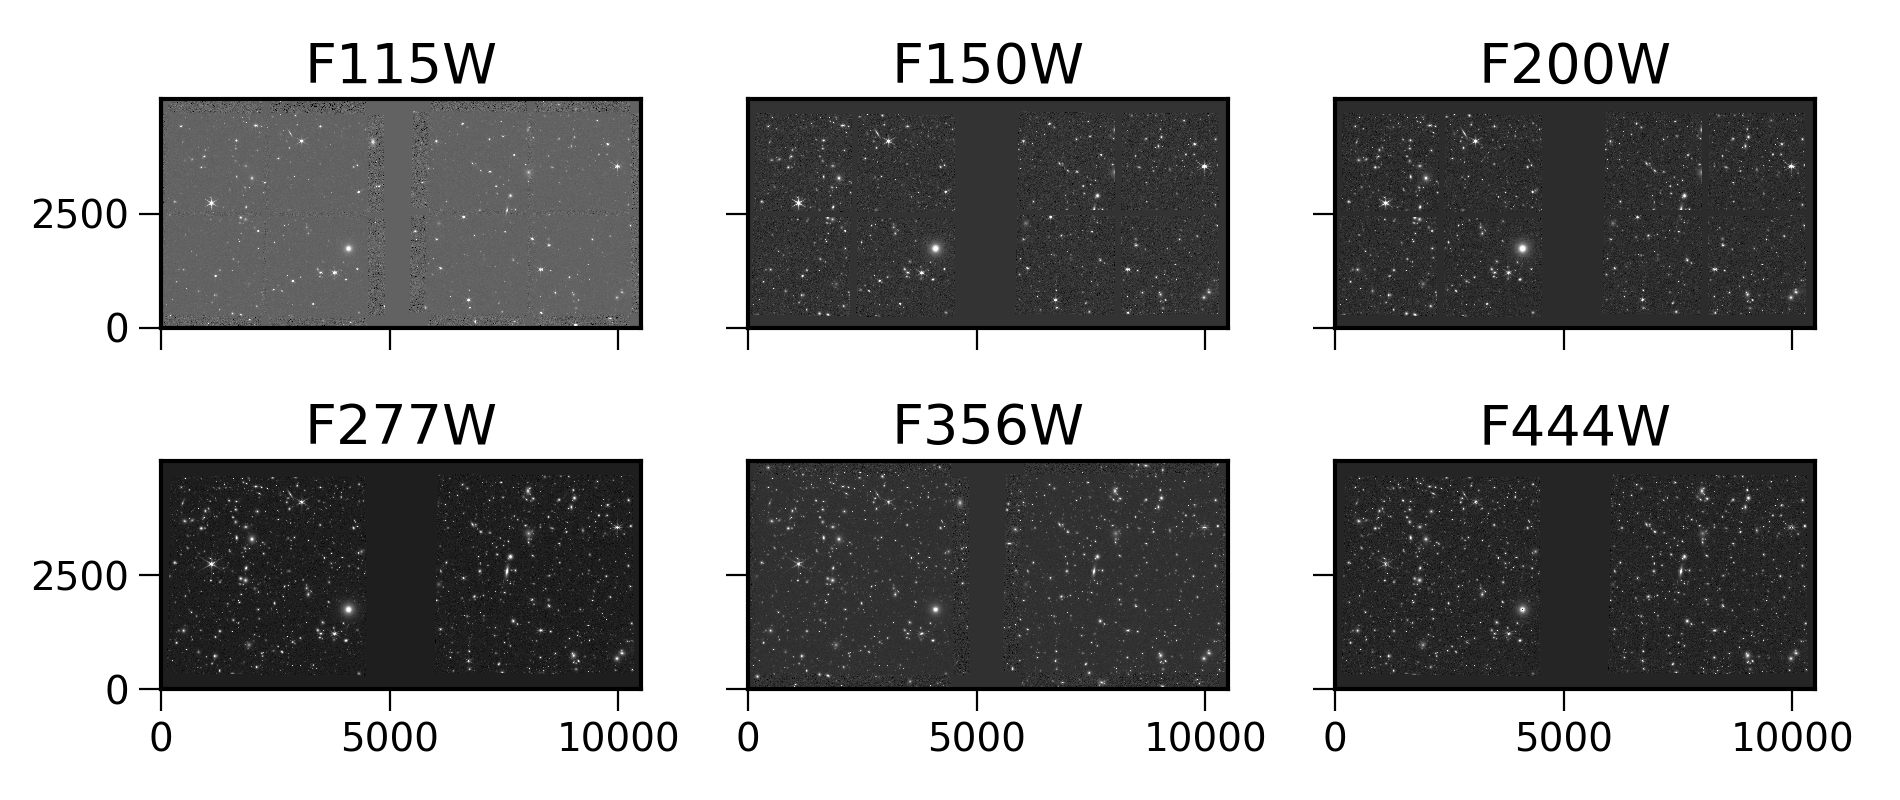

In [6]:
field = 'ceers5'
filters = 'F115W F150W F200W F277W F356W F444W'.split()
image_files = ['../images/%s_%s_sci.fits.gz' % (field, filt.lower()) for filt in filters]
idata = 1  # index where science data is

fig, ax = plt.subplots(2, 3, figsize=(9.5,4), sharex=True, sharey=True)

for i, filt in enumerate(filters):
    iy = i // 3
    ix = i % 3
    hdu = pyfits.open(image_files[i])
    data = hdu[idata].data
    norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
    ax[iy,ix].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r')
    ax[iy,ix].set_title(filt)

# Start here

In [7]:
# Set filters, target name, and file name format

#filters = 'F115W F200W F444W'.split(); out_ext = ''
#filters = 'F277W F356W F444W'.split(); out_ext = 'lw'
#filters = 'F115W F150W F200W'.split(); out_ext = 'sw'
# these CEERS filters include greatest out of field coverage to support NIRCam WFSS
filters = 'F115W F200W F356W'.split(); out_ext = '' 
field = 'ceers5'  # insert target name here

image_files = ['../images/%s_%s_sci.fits.gz' % (field, filt.lower()) for filt in filters]
idata = 1  # index where science data is

num_images = len(image_files)
image_files

['../images/ceers5_f115w_sci.fits.gz',
 '../images/ceers5_f200w_sci.fits.gz',
 '../images/ceers5_f356w_sci.fits.gz']

In [8]:
for i in range(num_images):
    hdu = pyfits.open(image_files[i])
    data = hdu[idata].data
    ny, nx = data.shape
    imwcs = wcs.WCS(hdu[idata].header, hdu)
    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = '%d x %d pixels' % (ny, nx)
    outline += ' = %d" x %d"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += " = %.1f' x %.1f'" % (ny * image_pixel_scale / 60., nx * image_pixel_scale / 60.)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)

5000 x 10500 pixels = 149" x 314" = 2.5' x 5.2' (0.03" / pixel)
5000 x 10500 pixels = 149" x 314" = 2.5' x 5.2' (0.03" / pixel)
5000 x 10500 pixels = 149" x 314" = 2.5' x 5.2' (0.03" / pixel)


In [9]:
r = fits.open(image_files[2])[idata].data
g = fits.open(image_files[1])[idata].data
b = fits.open(image_files[0])[idata].data

rgb_data = np.array([r, g, b]).transpose((1,2,0))  # (3, ny, nx) -> (ny, nx, 3)
rgb_data.shape

(5000, 10500, 3)

In [10]:
if 0:
    # Lupton color image
    color_image = make_lupton_rgb(r, g, b, Q=10, stretch=0.07)  # , minimum=(0.25, 0.11, 0.12))
    fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
    # For RA,Dec axes instead of pixels, add: , subplot_kw={'projection': imwcs})
    plt.imshow(color_image, origin='lower')
    #plt.xlabel('Right Ascension')
    #plt.ylabel('Declination')
    #plt.title('Short Wavelength Channel')

In [11]:
if 0:
    # Show each image as grayscale

    fig, ax = plt.subplots(1, num_images, sharex=True, sharey=True, figsize=(9.5, 3))
    # For RA,Dec axes instead of pixels, add: , subplot_kw={'projection': imwcs})

    norm_images = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=1)

    for i in range(num_images):
        data = pyfits.open(image_files[i])[idata].data
        ax[i].imshow(data, origin='lower', cmap='Greys_r', norm=norm_images)
        ax[i].set_title(filters[i])

    fig.tight_layout()

    print('Interactive zoom / pan controls all images simultaneously')

# Sample a region of the image and make a color stamp

## Iterate until it looks good

In [12]:
rgb_stamps = image_stamps(rgb_data, sample_size=1000, dx=-1800, dy=1000)
rgb_stamps.shape

(1000, 1000, 3)

In [13]:
noiselum = 0.10
satpercent = 0.01
unsatpercent = 1 - 0.01 * satpercent

In [14]:
scaled_images = []
levels_rgb = []
for i in range(3):
    levels = determine_scaling(rgb_stamps[:,:,i].ravel(), unsatpercent)
    levels_rgb.append(levels)
    print(levels)
    print()
    scaled = imscale2(rgb_stamps[:,:,i], levels, noiselum)
    scaled_images.append(scaled)
    
imrgb = np.array(scaled_images[::-1]).transpose((1,2,0))
imrgb.shape

0.000395303 +/- 0.00288328
(-0.00537125434493646, 0.003278581949416548, 1.8004924)

0.00117457 +/- 0.00602753
(-0.010880494490265846, 0.007202100940048695, 1.0234063)

0.00054177 +/- 0.00764333
(-0.014744897605851293, 0.008185103302821517, 0.5108686)



(1000, 1000, 3)

<IPython.core.display.Javascript object>


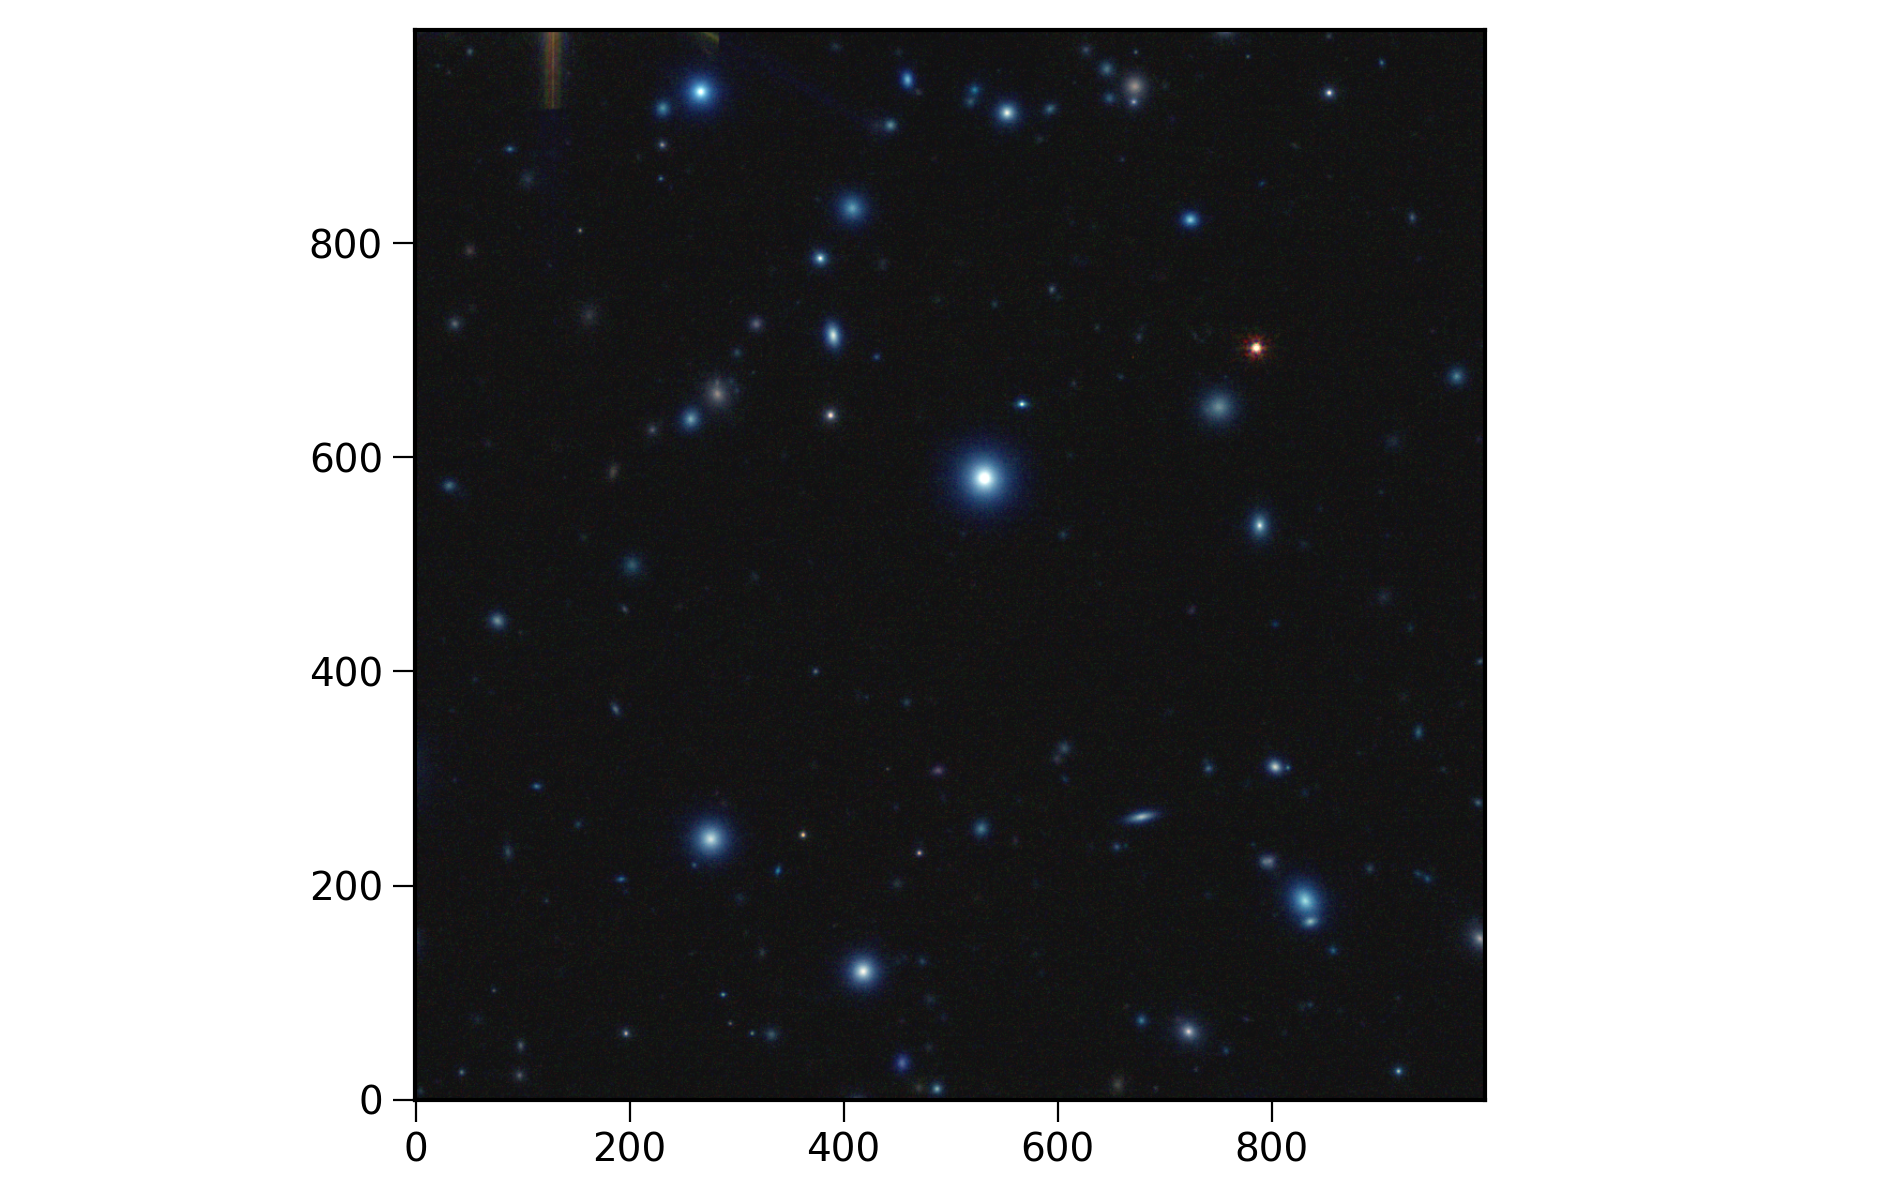

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plt.imshow(imrgb, origin='lower')

## Once you're happy with the color image stamp,
# Create and save the color full image

In [16]:
scaled_images = []
for i in range(3):
    levels = levels_rgb[i]
    scaled = imscale2(rgb_data[:,:,i], levels, noiselum)
    scaled_images.append(scaled)
    
imrgb = np.array(scaled_images[::-1]).transpose((1,2,0))
imrgb.shape

(5000, 10500, 3)

In [17]:
import matplotlib
outfile = field + '_color.png'
if out_ext:
    outfile = outfile.replace('.png', '_'+out_ext+'.png')
    
if os.path.exists(outfile):
    print(outfile, 'EXISTS')
else:
    print('SAVING', outfile)
    matplotlib.image.imsave(outfile, imrgb)

SAVING ceers5_color.png


<IPython.core.display.Javascript object>


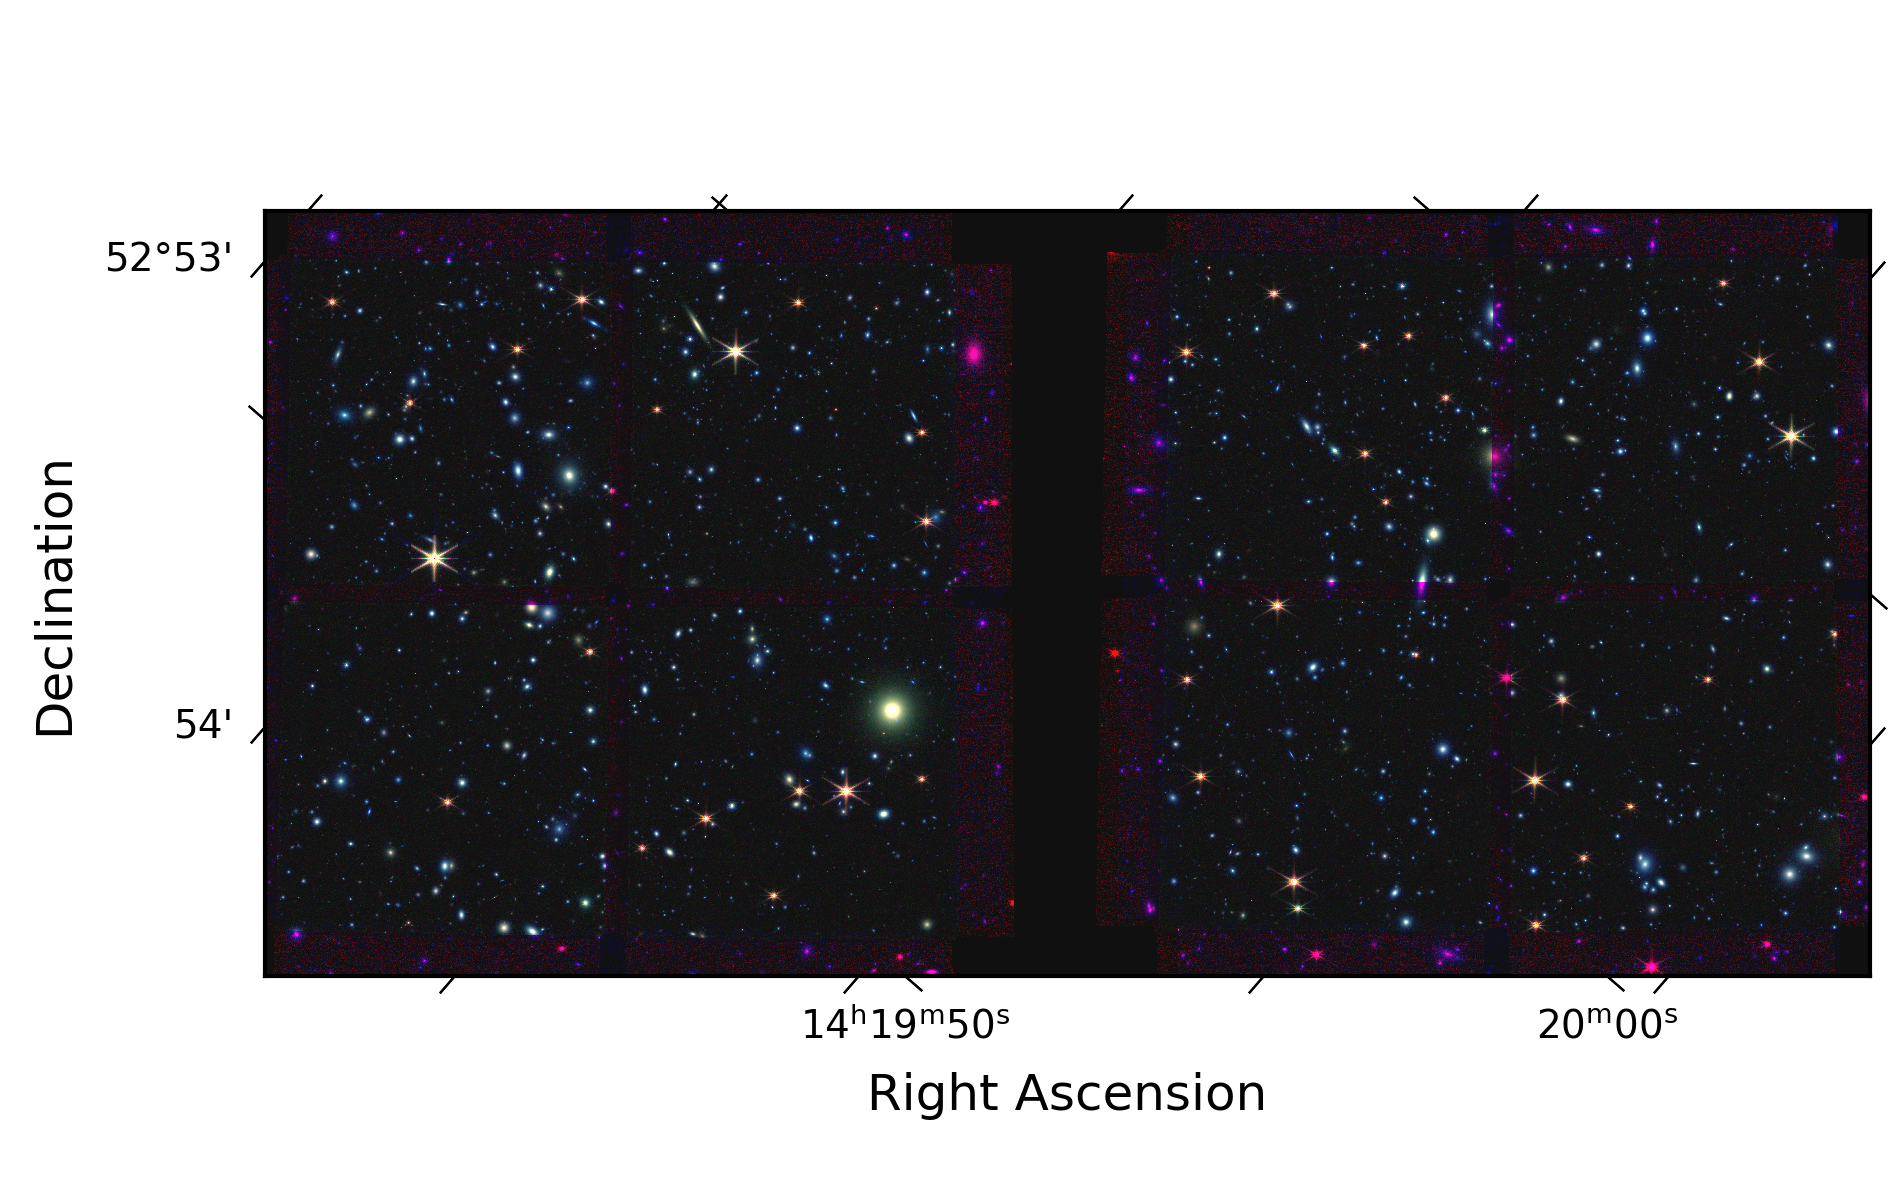

In [18]:
fig = plt.figure(figsize=(9.5, 6))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(imrgb, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')